In [1]:
import numpy
%matplotlib notebook
import matplotlib.pyplot
import scipy.interpolate
import scipy.integrate
import pynverse

# Arc Length Reparameterization

## Overview

To have control over the speed and acceleration of an object along a path, the path should be parameterized on distance. It is much easier to express a parameterized curve in terms of time, so we need to convert it from time-parameterized to arc-length-parameterized.

## Time-Parameterized

The original equation we wish to convert to arc-length-parameterized is a spline curve connecting two roads. The details of the curve are irrelevant so we will focus on a specific example without loss of generality. Consider the following curves:

$$ \vec{\ell}_a(t) = \langle 3, t \rangle \quad \forall t \in [0, 1] $$
$$ \vec{\ell}_b(t) = \langle 1 - t, 3 \rangle \quad \forall t \in [0, 1] $$

In [2]:
l_a = lambda t: numpy.array([[3 + 0 * t], [0 + 1 * t]])
l_b = lambda t: numpy.array([[1 - 1 * t], [3 + 0 * t]])

To get a better idea of these curves, here they are plotted.

<IPython.core.display.Javascript object>


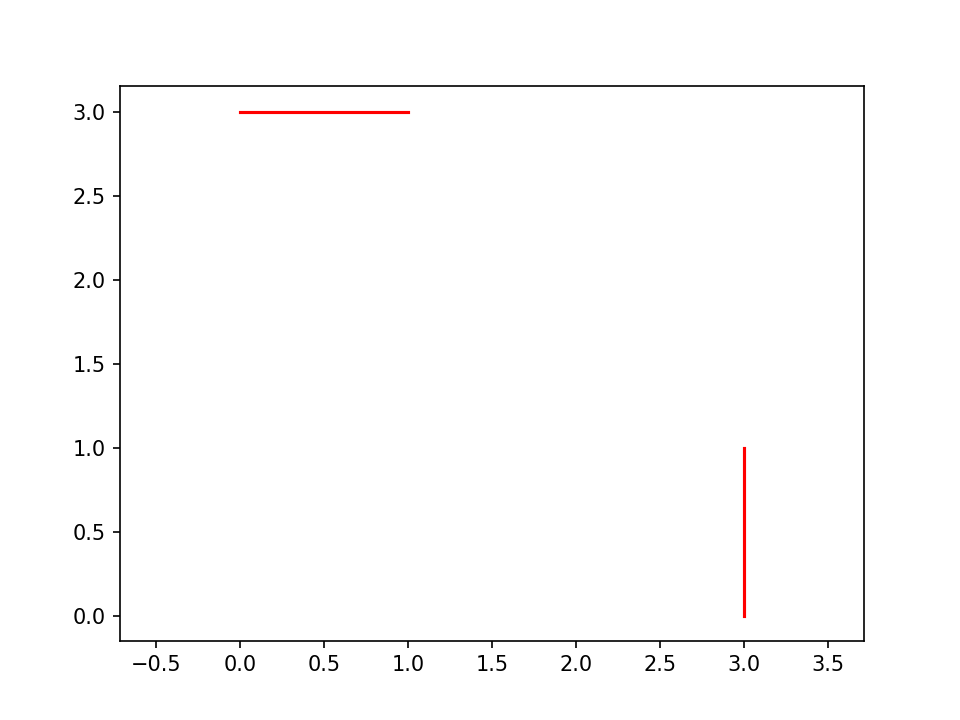

In [3]:
fig, ax = matplotlib.pyplot.subplots()

t_a = t_b = numpy.linspace(0, 1, 100)

ax.plot(l_a(t_a)[0].flatten(), l_a(t_a)[1].flatten(), 'r-')
ax.plot(l_b(t_b)[0].flatten(), l_b(t_b)[1].flatten(), 'r-')

ax.axis('equal')

matplotlib.pyplot.show()

Now we can connect them with a spline interpolation. We will call it `time_path` to differentiate from the arc-length parameterized expression later. This path will now be referenced using the following symbols

$$ \ell(t) = \langle x(t), y(t) \rangle \quad \forall t \in [0, 1] $$

In [4]:
t_a = t_b = numpy.linspace(0, 1, 100)

xs = numpy.hstack([l_a(t_a)[0].flatten(), l_b(t_b)[0].flatten()])
ys = numpy.hstack([l_a(t_a)[1].flatten(), l_b(t_b)[1].flatten()])

time_spline, _ = scipy.interpolate.splprep([xs, ys], s=0)

time_path = lambda t: numpy.array(scipy.interpolate.splev(t, time_spline, der=0))

To confirm the interpolation is correct, we can plot the result.

<IPython.core.display.Javascript object>


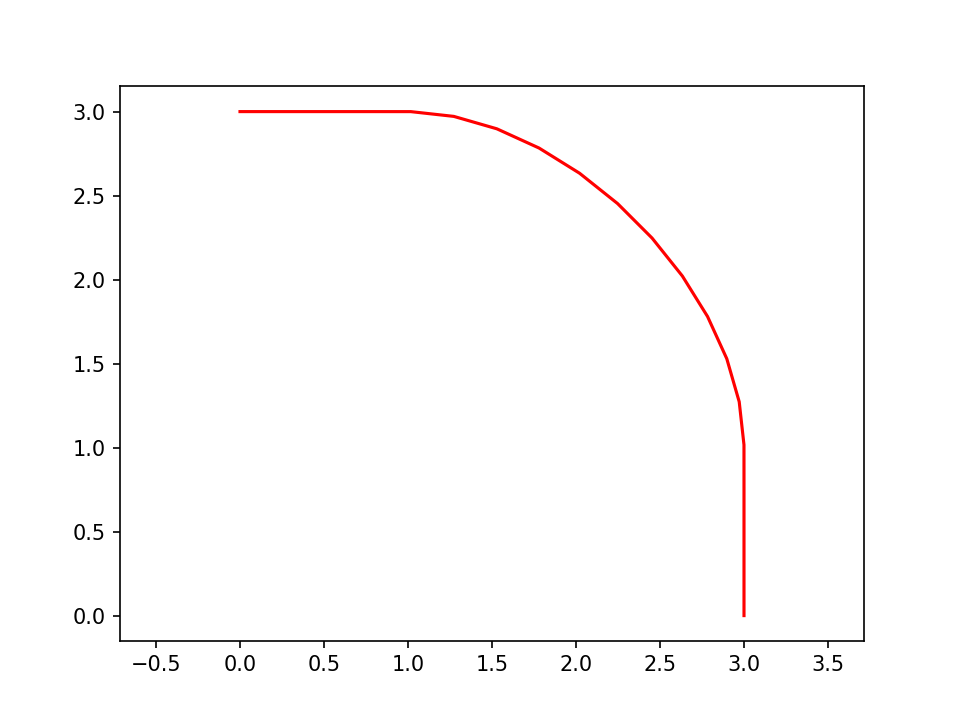

In [5]:
fig, ax = matplotlib.pyplot.subplots()

t = numpy.linspace(0, 1, 20)
ax.plot(time_path(t)[0], time_path(t)[1], 'r-')

ax.axis('equal')

matplotlib.pyplot.show()

## Speed

Before we reparameterize the curve, we will investigate why time-parameterization is insufficient. First we calculate the velocity and speed of the curve.

$$ \vec{v}(t) = \left\langle \frac{\partial x}{\partial t}(t), \frac{\partial y}{\partial t}(t) \right\rangle \quad \forall t \in [0, 1] $$
$$ v(t) = \left\lVert \left\langle \frac{\partial x}{\partial t}(t), \frac{\partial y}{\partial t}(t) \right\rangle \right\rVert \quad \forall t \in [0, 1] $$

SciPy has built in functions for calculating the derivatives of spline curves.

In [6]:
time_path_gradient = lambda t: numpy.array(scipy.interpolate.splev(t, time_spline, der=1))
time_path_speed = lambda t: numpy.linalg.norm(time_path_gradient(t), axis=0)

Over time, we want constant speed along the curve. Let's plot the curve to see if this is the case.

<IPython.core.display.Javascript object>


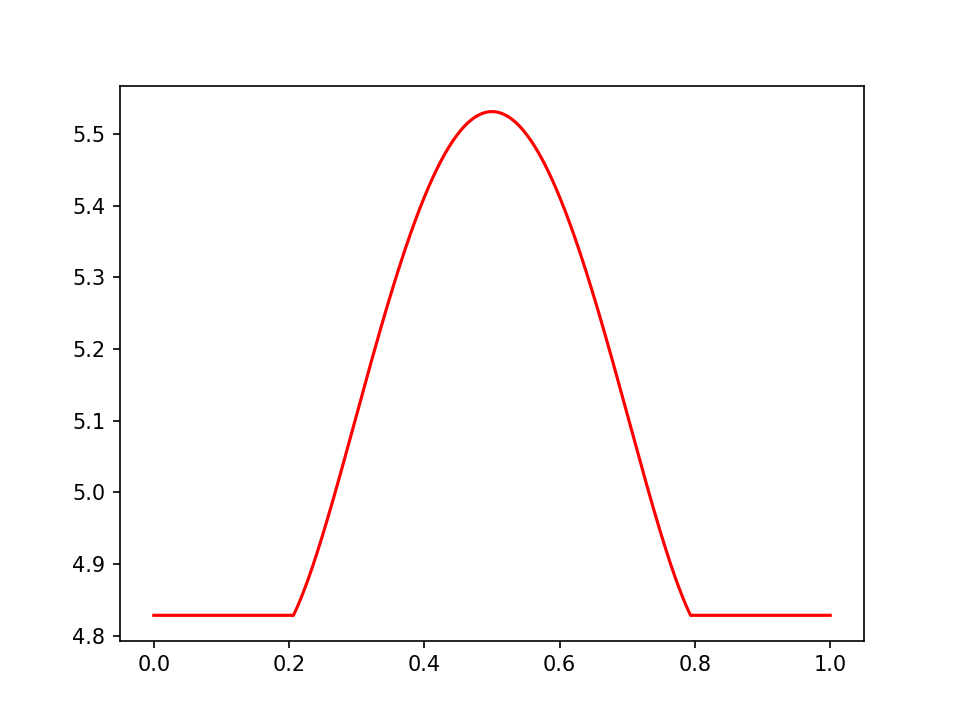

In [7]:
fig, ax = matplotlib.pyplot.subplots()

t = numpy.linspace(0, 1, 1000)
ax.plot(t, time_path_speed(t), 'r-')

matplotlib.pyplot.show()

Unfortunately, the speed doesn't remain constant over the turn. Granted, it is a small difference, but it is still there and could cause trouble.

## Arc-Length-Parameterized

The first task is to determine the length of the curve from starting position at a specific time.

$$ L(t) = \int_0^t \left\lVert \left\langle \frac{\partial x}{\partial t}(t), \frac{\partial y}{\partial t}(t) \right\rangle \right\rVert dt = \int_0^t v(t) dt $$

We can use SciPy's integration `quad` technique and the speed function calculated above to evaluate this expression.

In [8]:
length = lambda t: scipy.integrate.quad(time_path_speed, 0, t)[0]

The total length of the curve is given by

$$ L_{\mathrm{total}} = \int_0^1 \left\lVert \left\langle \frac{\partial x}{\partial t}(t), \frac{\partial y}{\partial t}(t) \right\rangle \right\rVert dt = \int_0^1 v(t) dt $$

Using the total length, we can normalized the length function so $L^*(t) \in [0, 1]$.

$$ L^*(t) = \frac{L(t)}{L_{\mathrm{total}}} = \frac{1}{L_{\mathrm{total}}} \int_0^t \left\lVert \left\langle \frac{\partial x}{\partial t}(t), \frac{\partial y}{\partial t}(t) \right\rangle \right\rVert dt = \frac{1}{L_{\mathrm{total}}} \int_0^t v(t) dt $$

In [9]:
length_total = length(1)
length_star = lambda t: length(t) / length_total

We can now plot the length with respect to time. If the speed were constant, this would be a perfectly linear relationship. Since we know it is not, there should be a slight divergence.

<IPython.core.display.Javascript object>


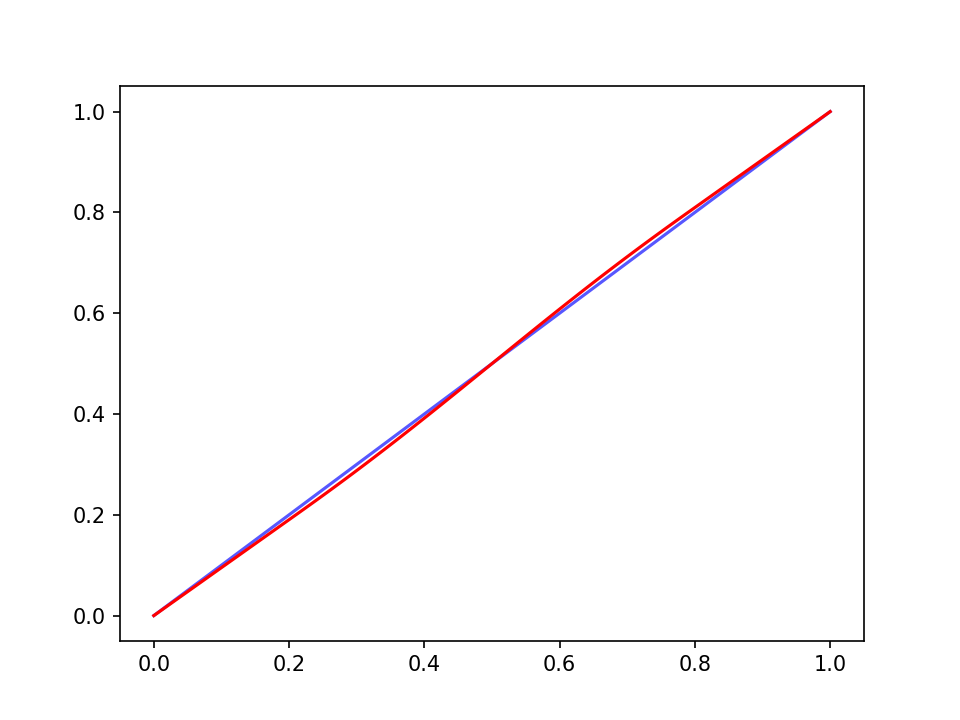

In [10]:
fig, ax = matplotlib.pyplot.subplots()

t = numpy.linspace(0, 1, 100)
ax.plot(t, t, 'b-', alpha=0.66)
ax.plot(t, numpy.vectorize(length_star)(t), 'r-')

matplotlib.pyplot.show()

Notice that this plot took a long time to compute. We naively `vectorize` the length expression to allow for array inputs. This is super slow and, if you think about it for a second, very wasteful. Using the `cumtrapz` function, this can be significantly optimized as we can compute the integration values within a range cumulatively without iteration, but the intuition might be less clear.

<IPython.core.display.Javascript object>


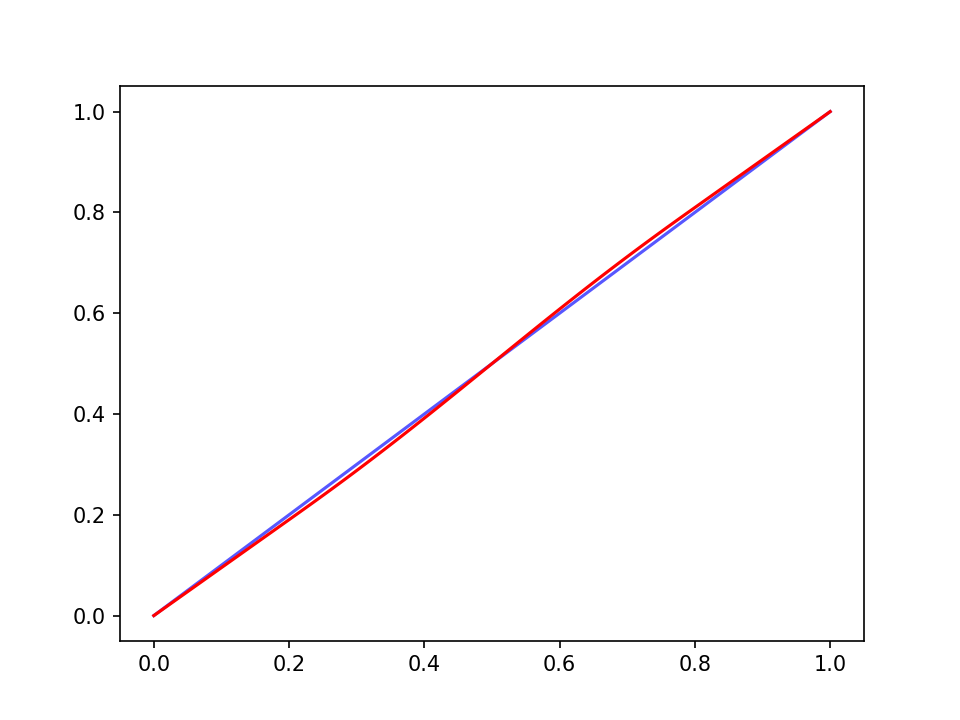

In [11]:
fig, ax = matplotlib.pyplot.subplots()

t = numpy.linspace(0, 1, 100)
ax.plot(t, t, 'b-', alpha=0.66)
ax.plot(t, scipy.integrate.cumtrapz(time_path_speed(t) / length_total, t, initial=0), 'r-')

matplotlib.pyplot.show()

The next step to reparameterize with respect to arc-length is to invert the normalized length function. This allows us to define the curve in the following way

$$ \ell(s^*) = \left\langle x\left(L^{-1}(s^*)\right), y\left(L^{-1}(s^*)\right) \right\rangle \quad \forall s^* \in [0, 1] $$

Unfortunately, our length function doesn't have a known analytical form. Therefore, we have to compute the inverse numerically. Because our functions are normalized, we can compute several points in the range $[0, 1]$ and fit a spline curve to the inverted data. This will approximate our inverse.

In [12]:
t = numpy.linspace(0, 1, 100)

length_star_inverse_spline = scipy.interpolate.splrep(scipy.integrate.cumtrapz(time_path_speed(t) / length_total, t, initial=0), t, s=0)

length_star_inverse = lambda t: scipy.interpolate.splev(t, length_star_inverse_spline)

Let's plot the inverse to make sure the output makes sense.

<IPython.core.display.Javascript object>


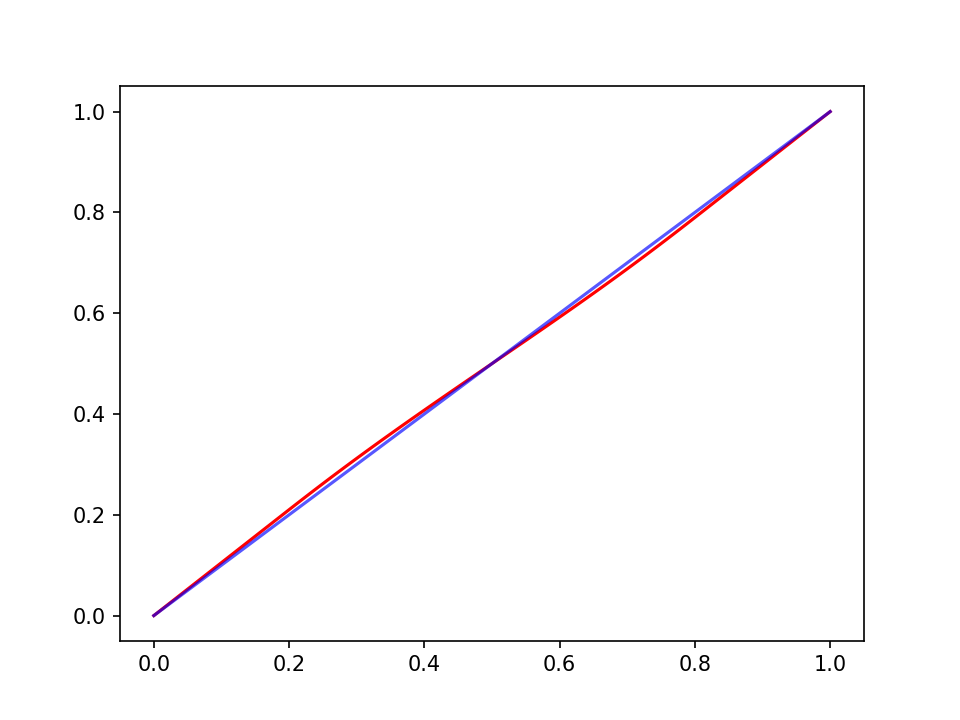

In [13]:
fig, ax = matplotlib.pyplot.subplots()

t = numpy.linspace(0, 1, 100)
ax.plot(t, length_star_inverse(t), 'r-')
ax.plot(t, t, 'b-', alpha=0.66)

matplotlib.pyplot.show()

Now we have all the necessary components to reparameterized the curve with respect to arc-length.

In [14]:
arc_length_path = lambda s: time_path(length_star_inverse(s))

We will also need the gradient of the arc-length-parameterized path. To make the numerical gradient more accurate, we fit to a spline one last time.

In [15]:
s = numpy.linspace(0, 1, 100)
arc_length_spline, _ = scipy.interpolate.splprep(arc_length_path(s), s=0)

arc_length_path = lambda s: numpy.array(scipy.interpolate.splev(s, arc_length_spline, der=0))
arc_length_path_gradient = lambda s: numpy.array(scipy.interpolate.splev(s, arc_length_spline, der=1))
arc_length_path_speed = lambda s: numpy.linalg.norm(arc_length_path_gradient(s), axis=0)

First we can plot the paths to make sure they align.

<IPython.core.display.Javascript object>


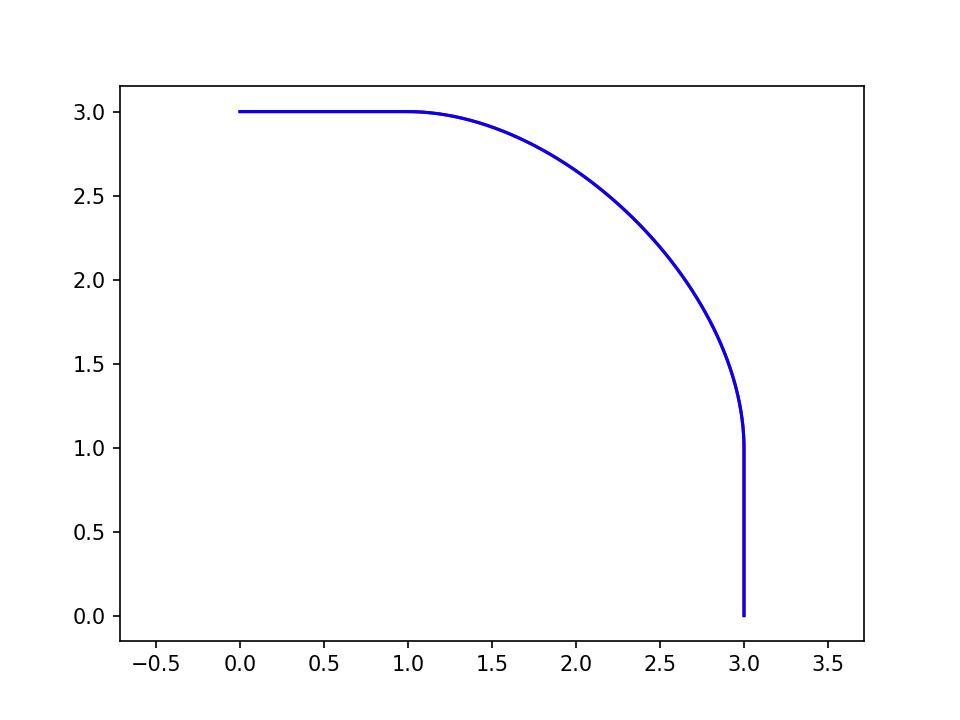

In [16]:
fig, ax = matplotlib.pyplot.subplots()

s = numpy.linspace(0, 1, 100)
t = numpy.linspace(0, 1, 100)

ax.plot(arc_length_path(s)[0], arc_length_path(s)[1], 'r-')
ax.plot(time_path(t)[0], time_path(t)[1], 'b-')

ax.axis('equal')

matplotlib.pyplot.show()

And we can compare the speed versus time graphs. The reparameterized graph should be constant.

<IPython.core.display.Javascript object>


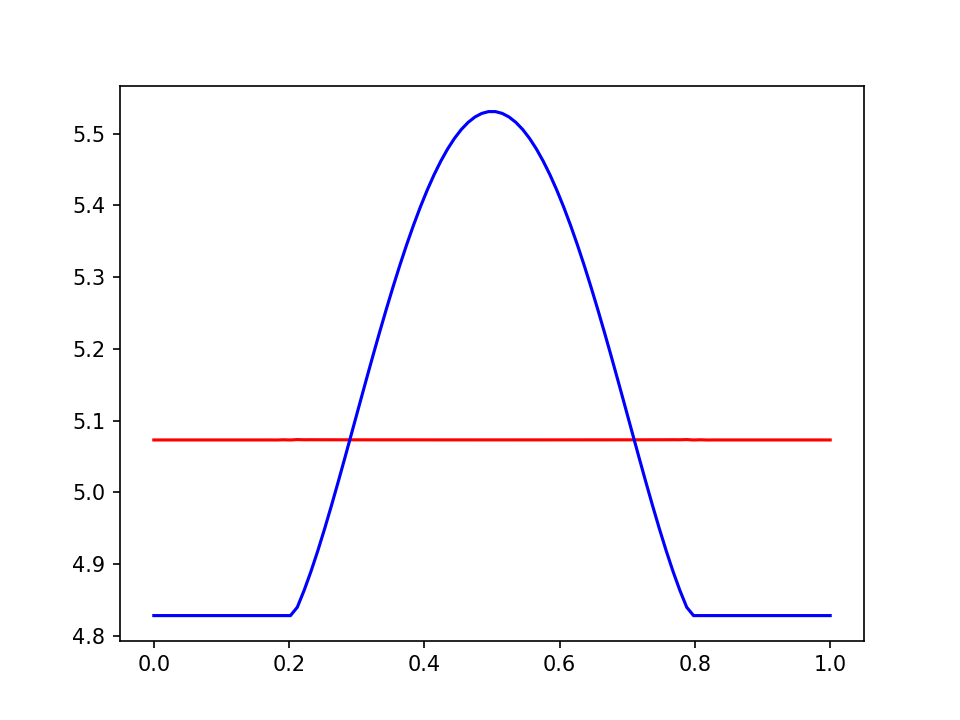

In [17]:
fig, ax = matplotlib.pyplot.subplots()

s = numpy.linspace(0, 1, 100)
t = numpy.linspace(0, 1, 100)

ax.plot(s, arc_length_path_speed(s), 'r-')
ax.plot(t, time_path_speed(t), 'b-')

matplotlib.pyplot.show()

Although there is a slight jag in the red curve (if you zoom in) where the turn begins and ends, it is a vast improvement over the previous curve definition.

## Direction

Lastly, we will need the direction of travel at any point along the curve given a particular length-position. We already calculated this in our speed calculation. We plot a few vectors to confirm the legitimacy of the gradient.

<IPython.core.display.Javascript object>


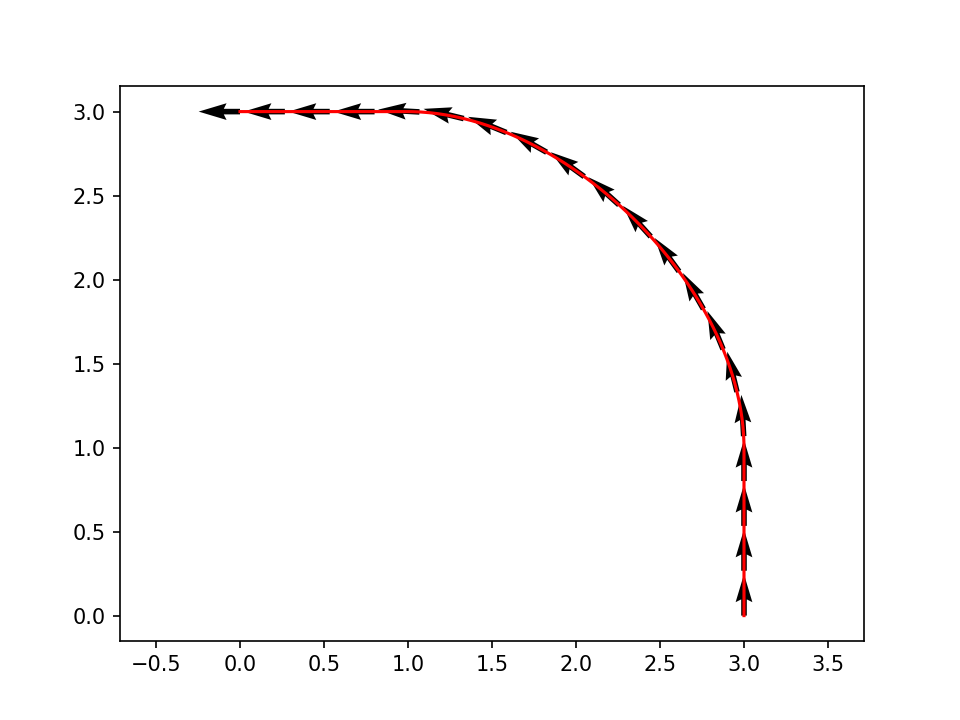

In [18]:
fig, ax = matplotlib.pyplot.subplots()

s = numpy.linspace(0, 1, 100)
ax.plot(arc_length_path(s)[0], arc_length_path(s)[1], 'r-')
s = numpy.linspace(0, 1, 20)
ax.quiver(arc_length_path(s)[0], arc_length_path(s)[1], arc_length_path_gradient(s)[0], arc_length_path_gradient(s)[1])

ax.axis('equal')

matplotlib.pyplot.show()